# CS156 Assignment 4 

For this assignment, I'll be using the Image net data, specifically the man and woman images where I try to classify if a clothing is for man or woman. The data set consists of over 2,000 images and will be using PCA and LDA. 

In [1]:
from glob import glob
from PIL import Image
from resizeimage import resizeimage
import numpy as np
import matplotlib.pyplot as plt

# create paths for all images
man_clothes = glob('man/*')
woman_clothes = glob('woman/*')

## Data Preprocessing

In [2]:
def image_resize(images, size):
    """
    This function is used from Session 7.1 where we use to 
    resize images.
    """
    flattened = []
    # for each image path
    for path in images:
        # open it as a read file in binary mode
        with open(path, 'r+b') as f:
            # open it as an image
            with Image.open(f) as image:
                # resize the image to be more manageable
                cover = resizeimage.resize_cover(image, size)
                # flatten the matrix to an array and append it to all flattened images
                flattened.append((np.array(cover).flatten(), 0))

    # Flatten it once more
    flattened = np.asarray(flattened, dtype = object)

    # Declare which are the X and Y inputs
    X = flattened[:,0]
    Y = flattened[:,1]

    # Use np.stack to put the data into the right dimension
    X = np.stack(i for i in X)
    Y = np.stack(i for i in Y)
    
    return X, Y


In [3]:
%%time

# chosen size reduction 
size = [50,150]

man_images = image_resize(man_clothes, size)[0]
woman_images = image_resize(woman_clothes, size)[0]

#Check data shape 
print(man_images.shape) 
print(woman_images.shape) 

/Users/lancelot/opt/anaconda3/lib/python3.8/site-packages/IPython/core/magics/execution.py:1321: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  exec(code, glob, local_ns)


(1242, 22500)
(1270, 22500)
CPU times: user 13.6 s, sys: 815 ms, total: 14.4 s
Wall time: 16.8 s


#### NOTE 

This error can be ignored since we do not need to implement the function again and that we have the desired dimensions. 

In [4]:
## Add classes and merge data 

# Add 1 for men and 0 for women classes 
new_column_ones = np.ones((len(man_images), 1))
new_column_zeros = np.zeros((len(woman_images), 1))

class_man_images = np.append(man_images, new_column_ones, axis = 1)
class_woman_images = np.append(woman_images, new_column_zeros, axis = 1)

print(class_man_images.shape)
print(class_woman_images.shape)

images_data = np.concatenate((class_man_images, class_woman_images), axis = 0)

print(images_data.shape)

(1242, 22501)
(1270, 22501)
(2512, 22501)


In [5]:
from sklearn.model_selection import train_test_split

X = images_data[:, 0:-1] # select all except the last column 
y = images_data[:, -1] # select last column 

print(X.shape)
print(y.shape)

# Splitting training and testing for 80% and 20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 24)

print("Split data: ")
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)


(2512, 22500)
(2512,)
Split data: 
(2009, 22500)
(503, 22500)
(2009,)
(503,)


## Using Logistic Regression without PCA or LDA 

In [6]:
from sklearn.linear_model import LogisticRegression 
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn import metrics

In [7]:
%%time 

# need to make pipeline to help with convergence 
logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 500))

logreg.fit(X_train, y_train)

logreg_pred = logreg.predict(X_test)

# Acquire Metrics 
logreg_training_score = logreg.score(X_train, y_train)
logreg_testing_score = logreg.score(X_test, y_test)

print("---SCORES---")
print("Training Score:", logreg_training_score)
print("Testing Score:", logreg_testing_score)

/Users/lancelot/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


---SCORES---
Training Score: 0.9995022399203584
Testing Score: 0.5805168986083499
CPU times: user 3min 14s, sys: 6.74 s, total: 3min 21s
Wall time: 20.7 s


### Correction with a simple Validation step 

Based on this error, it seems like our model fails to converge despite after standardizing the data set. I also see that there is a tendency for overfitting the data and therefore, I performed a validation by splitting the training data to 80-20 to check for the best regularization parameter: C. 

In [8]:
# Create validation set 
X_CV_train, X_CV_test, y_CV_train, y_CV_test = train_test_split(X_train, y_train, 
                                                                test_size = 0.2, random_state = 24)

C_vals = [1e-12, 1e-11, 1e-10, 1e-9, 1e-8]

CV_training_scores = []
CV_testing_scores = [] 

for c in C_vals:
    # need to make pipeline to help with convergence 
    logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 500, C = c))

    logreg.fit(X_CV_train, y_CV_train)

    logreg_pred = logreg.predict(X_CV_test)

    # Acquire Metrics 
    CV_training_scores.append(logreg.score(X_CV_train, y_CV_train))
    CV_testing_scores.append(logreg.score(X_CV_test, y_CV_test))


[]

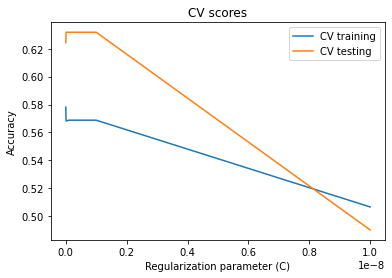

In [9]:
# Plotting CV scores 

plt.plot(C_vals, CV_training_scores, label = 'CV training')
plt.plot(C_vals, CV_testing_scores, label = 'CV testing')
plt.legend()
plt.title("CV scores")
plt.xlabel("Regularization parameter (C)")
plt.ylabel("Accuracy")
plt.plot()

In [24]:
# c value of 1e-10 is our best value since it returns the best test score and we use this in our 
# original model 
logreg = make_pipeline(StandardScaler(), LogisticRegression(max_iter = 500, C = 1e-10))

logreg.fit(X_CV_train, y_CV_train)

logreg_pred = logreg.predict(X_test)

# Acquire Metrics 
logreg_training_score = logreg.score(X_CV_train, y_CV_train)
logreg_testing_score = logreg.score(X_test, y_test)

print("---SCORES---")
print("Training Score:", logreg_training_score)
print("Testing Score:", logreg_testing_score)

---SCORES---
Training Score: 0.5687616677037959
Testing Score: 0.5666003976143141


### NOTE 
We see that the model is now running properly and there is no more overfitting between the training and testing scores. 

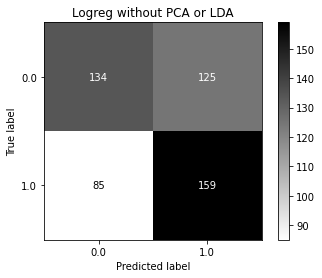

In [11]:
# Plot confusion metrics 
metrics.plot_confusion_matrix(logreg, X_test, y_test, cmap = 'binary')
plt.title("Logreg without PCA or LDA")
plt.show()

## Logistic Regression with PCA 

As the first step, we would just like to check on how the trend of the scree plot behaves when we apply PCA. Here we just test up until 20 n_components since beyond that would just be purely flat variance and would be really small to see. 

Data shape: (2009, 20) (503, 20)


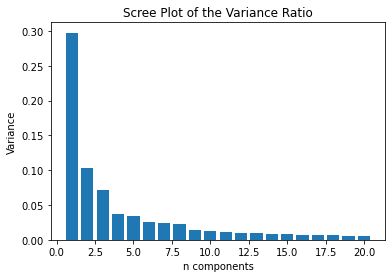

In [12]:
# Checking how PCA works out on the scree plot 
from sklearn import decomposition

# We will by looking at how much variance we get 
n_components = 20

pca = decomposition.PCA(n_components = n_components)
X_PCA_train = pca.fit_transform(X_train)
X_PCA_test = pca.fit_transform(X_test)

print("Data shape:", X_PCA_train.shape, X_PCA_test.shape)

# Plot the variance on a scree plot 
def plot_scree(n_comp, pca_var):
    plt.bar(np.linspace(1, n_comp, n_comp),pca_var)

    plt.title("Scree Plot of the Variance Ratio")
    plt.xlabel("n components")
    plt.ylabel("Variance")

    plt.show()
    
plot_scree(n_components, pca.explained_variance_ratio_)



#### Using multiple n_comps 

Here, we trying to measure the training and testing score using different n_comps for our PCA and logreg. 

In [13]:
def PCA_logreg_metrics(X_train, X_test, y_train, y_test, n_comps): 
    """
    This function aims to check on the training and testing 
    scores with varying n_commponents set for the PCA. 
    
    Input: data 
    Output: Training and testing scores 
    """
    # Metrics 
    training_scores = []
    testing_scores = []
    
    for n in n_comps: 
        # Fit PCA 
        pca = decomposition.PCA(n_components = n)
        X_PCA_train = pca.fit_transform(X_train)
        X_PCA_test = pca.fit_transform(X_test)
        
        # Fit LogReg 
        logreg = LogisticRegression(max_iter=100)
        logreg.fit(X_PCA_train, y_train)
        
        training_scores.append(logreg.score(X_PCA_train, y_train))
        testing_scores.append(logreg.score(X_PCA_test, y_test))
        
    return training_scores, testing_scores 

In [14]:
%%time 

# Get number of components from 1 to 99 
n_comps = np.linspace(1, 99, 99).astype('int64')

training_scores, testing_scores = PCA_logreg_metrics(X_train, X_test, y_train, y_test, n_comps)

CPU times: user 46min 23s, sys: 3min 1s, total: 49min 25s
Wall time: 5min 50s


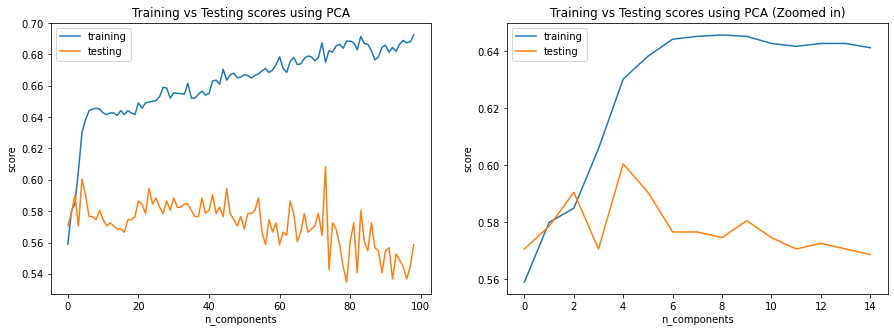

In [15]:
# Plot results 

fig, ax = plt.subplots(1,2, figsize = [15,5])

ax[0].plot(training_scores, label = 'training')
ax[0].plot(testing_scores, label = 'testing')
ax[0].set_title("Training vs Testing scores using PCA")
ax[0].set_xlabel("n_components")
ax[0].set_ylabel("score")
ax[0].legend()

ax[1].plot(training_scores[0:15], label = 'training')
ax[1].plot(testing_scores[0:15], label = 'testing')
ax[1].set_title("Training vs Testing scores using PCA (Zoomed in)")
ax[1].set_xlabel("n_components")
ax[1].set_ylabel("score")
ax[1].legend()


**NOTES**

0 - 10: good measure of n_components with high testing score 

15 and beyond: starting to overfit 

### Best PCA parameters

Based on the plot, I tried on different n_comps between 1-10 since it has the highest pair of training and testing scores. I ended up with 5. 

In [16]:
# We will by looking at how much variance we get 
n_components = 5

pca = decomposition.PCA(n_components = n_components)
X_PCA_train = pca.fit_transform(X_train)
X_PCA_test = pca.fit_transform(X_test)


logreg_PCA = LogisticRegression(max_iter=100)

logreg_PCA.fit(X_PCA_train, y_train)

logreg_pred = logreg_PCA.predict(X_PCA_test)

# Acquire Metrics 
logreg_PCA_training_score = logreg_PCA.score(X_PCA_train, y_train)
logreg_PCA_testing_score = logreg_PCA.score(X_PCA_test, y_test)

print("---SCORES---")
print("Training Score:", logreg_PCA_training_score)
print("Testing Score:", logreg_PCA_testing_score)

---SCORES---
Training Score: 0.6301642608262817
Testing Score: 0.6003976143141153


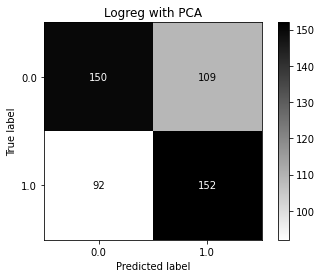

In [25]:
# Plot confusion matrix 
metrics.plot_confusion_matrix(logreg_PCA, X_PCA_test, y_test, cmap = 'binary')
plt.title("Logreg with PCA")
plt.show()

## Logistic Regression with LDA 

In [18]:
# Implement LDA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


In [19]:
%%time

# Fitting LDA 
lda = LinearDiscriminantAnalysis()

X_LDA_train = lda.fit_transform(X_train, y_train)
X_LDA_test = lda.transform(X_test)


CPU times: user 58.9 s, sys: 4.45 s, total: 1min 3s
Wall time: 17.7 s


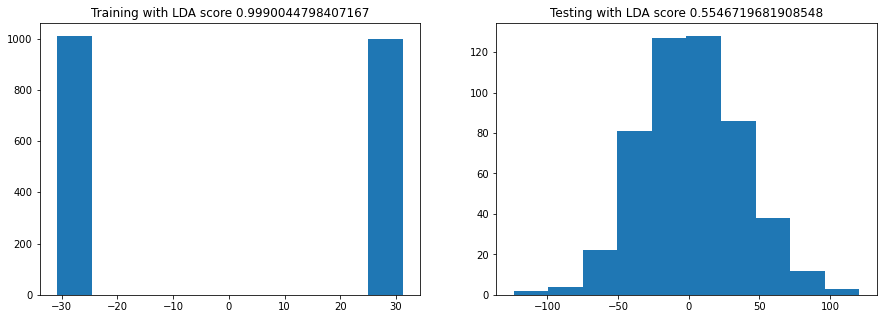

In [20]:
# See how our LDA performs 

fig, ax = plt.subplots(1,2, figsize = [15,5])

ax[0].hist(X_LDA_train)
ax[0].set_title(f"Training with LDA score {lda.score(X_train,y_train)}") 
ax[1].hist(X_LDA_test)
ax[1].set_title(f"Testing with LDA score {lda.score(X_test,y_test)}")

plt.show()

In [21]:
# Implementing with LogReg 

logreg_LDA = LogisticRegression(max_iter=100, C = 1e-10)

logreg_LDA.fit(X_LDA_train, y_train)

logreg_pred = logreg_LDA.predict(X_LDA_test)

# Acquire Metrics 
logreg_LDA_training_score = logreg_LDA.score(X_LDA_train, y_train)
logreg_LDA_testing_score = logreg_LDA.score(X_LDA_test, y_test)

print("---SCORES---")
print("Training Score:", logreg_LDA_training_score)
print("Testing Score:", logreg_LDA_testing_score)

---SCORES---
Training Score: 0.9990044798407167
Testing Score: 0.5546719681908548


### NOTE 

For the LDA model, I also performed a validation stepped where I tried different regularization parameters but it does not change the training and testing score and it is always equal to the LDA training and testing score after fitting to the logistic regression. I also attempted to apply the same process in linear SVM but the results were the same. Therefore, the LDA tends to overfit with the training data and resulting in a worse classification 

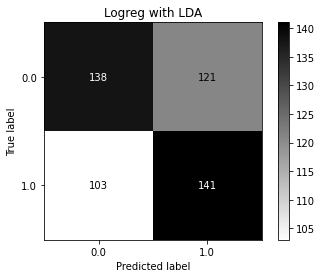

In [26]:
# Plot confusion matrix 
metrics.plot_confusion_matrix(logreg_LDA, X_LDA_test, y_test, cmap  = 'binary')
plt.title("Logreg with LDA")
plt.show()

## Summary of Analysis 


For this analysis, we will be looking at the confusion matrices and the scores of each of the model for comparison. 

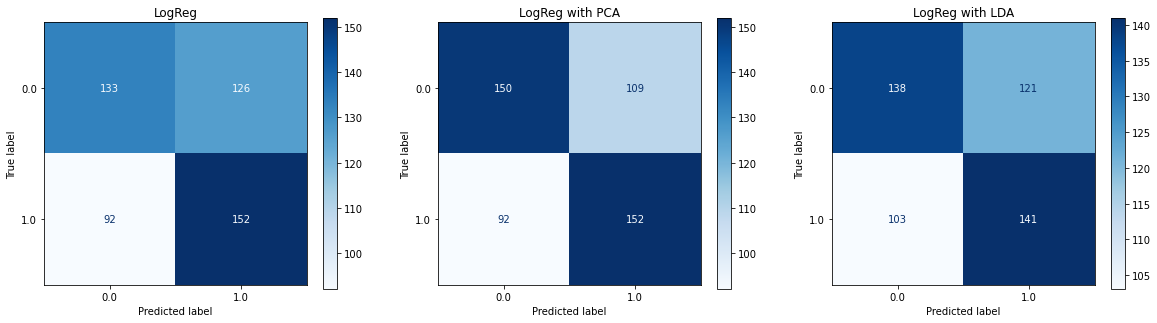

In [63]:
fig, axes = plt.subplots(1,3, figsize = [20,5])

classifiers = [logreg, logreg_PCA, logreg_LDA]
titles = ['LogReg', 'LogReg with PCA', 'LogReg with LDA'] 
X = [X_test, X_PCA_test, X_LDA_test]

counter = 0 
for cls, ax in zip(classifiers, axes.flatten()):
    metrics.plot_confusion_matrix(cls, 
                          X[counter], 
                          y_test, 
                          ax=ax, 
                          cmap='Blues')
    ax.set_title(titles[counter])
    counter += 1 
plt.show() 

fig, axes = plt.subplots(1,3, figsize = [20,5])


### Training and Testing Scores Table 

|                | LogReg | LogReg with PCA  | LogReg with LDA |
|----------------|--------|------------------|-----------------|
| Training Score | 0.5819 | 0.6302           | 0.9990          |
| Testing Score  | 0.5825 | 0.6004           | 0.5547          |

### Confusion Matrix

A common occurrence for all models is the error in predicting male clothing where a majority of the images for the male clothing is categorized as female. A main reason for this problem is perhaps the noise in the data set where some pictures have females in them and is very noisy in terms of the type of photo. Some photos are group photos of people wearing multiple clothes. To improve this, we might want to clean out the data set and select the only ones that can represent clothes only and not other individuals or other variables that are present in the photos. For all models, they seem to have more correct predictions that errors which is a good sign and the best model that is performing is the Logistic regression with the PCA. 


### Training and Testing Scores 

**Logistic Regression**

For the logistic regression model, we performed a validation step to determine a regularization parameter since we noticed an overfitting in the original data set. We then improved the model to which there is less overfitting and the resulting in a testing score that is slightly better than the training score. 

**Logistic Regression with the PCA** 

The application of PCA to the Logistic regression posed the best model compared to the other two. First, I look into the scree plot to see how the number of components change the variation captured by the transformation. Then, I tried different n_comps to transform the data set. Looking back to that plot, the model seems to improve itself as we increase the number of components from 1 to 10. Beyond that, the model starts to overfit and its testing scores are significantly diminished. However, we did not need to implement a regularization parameter for this model since the training and testing scores seem to not overfit when we use our best number of components (n_comps = 5). 

**Logistic Regression with LDA** 

Applying LDA to the model and using logistic regression seemed to overfit the training data by alot with a training score of almost 1. The testing score 0.55 which is worse than the Logistic Regression without PCA or LDA adjustments. I also tried using a validation step but changing the regularization parameter doesn't seem to change the training and testing score. I also tried using the Linear SVM instead of a logistic regression and the training and testing scores are still the same. 


### Recommendations 

Based on our results, the logistic regression with PCA is our best bet in doing the job for classifying male and female clothing since it has a better testing score and does not overfit. PCA allows us to just capture the highest variance amongst the data set and base our classification model from that transformed data. With a data set that varies a lot, this seems to be the best model. 

However, this is only for our training set and we must take note that we performed resizing in our images and that our data set is very noisy. Other improvements would be cleaning our data and checking for photos that do not really represent the proper class that we are aiming for (some photos are just group photos of people with both male and female individuals included). 